In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from scipy import stats
from statistics import stdev
import datetime
from datetime import timedelta
from collections import Counter
#import cx_Oracle
import psycopg2
import seaborn as sns
import json
import pickle
#from fitter import Fitter
from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
data = pd.read_pickle("./nl_sp_orders_from_tiers_51-56.pkl")

In [3]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4097787 entries, 0 to 4162692
Data columns (total 26 columns):
SCM_N_ORDER_POS_NR              int64
SCM_N_ORDER_NR                  int64
TDT_T_KEY_ORDER_DATE            datetime64[ns]
THR_C_KEY_ORDER_HOUR            object
SIT_N_KEY_SITE                  int64
CUS_N_KEY_CUSTOMER              int64
SCM_SALES_BMF                   float64
SCM_D_FINANCE_CM1               float64
SCM_D_FINANCE_CM2               float64
SCM_D_ORIG_FINANCE_ORDER_NET    float64
SCM_AP_ID                       int64
SCM_AS_ID                       int64
SCM_MASTER_AP_ID                int64
OSP_KO_COUNT_NET                int64
OSP_3_LEAD_P_PG_ID              float64
OSP_3_LEAD_P_PG_SHARE           float64
OSP_4_LEAD_P_PG_ID              float64
OSP_4_LEAD_P_PG_SHARE           float64
CZP_START_DATE                  datetime64[ns]
CZP_EXPIRY_DATE                 datetime64[ns]
CZP_ZTQ_ID                      int64
CZP_PERCENTAGE                  int64
CZP_PRI

In [4]:
data.head()

,SCM_N_ORDER_POS_NR,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,THR_C_KEY_ORDER_HOUR,SIT_N_KEY_SITE,CUS_N_KEY_CUSTOMER,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,...,OSP_4_LEAD_P_PG_ID,OSP_4_LEAD_P_PG_SHARE,CZP_START_DATE,CZP_EXPIRY_DATE,CZP_ZTQ_ID,CZP_PERCENTAGE,CZP_PRICE,ORDER_DATETIME,WEEK_NUMBER,MONTH_NUMBER
0,407357158,95471919,2017-10-01,19:51,7,15503176,2.490,1.2479,1.0368,2.0579,...,152.0,0.9476,2016-11-12 18:33:00,2017-10-31 18:16:00,56,5,4.99,2017-10-01 19:51:00,39,10
1,407287233,95455387,2017-10-01,16:28,7,16732336,4.995,0.8281,-0.5538,4.1281,...,80138.0,0.3038,2017-04-30 14:00:00,2018-04-30 23:59:00,56,5,4.99,2017-10-01 16:28:00,39,10
2,407287233,95455387,2017-10-01,16:28,7,16732336,4.995,0.8281,-0.5538,4.1281,...,80138.0,0.3038,2017-04-30 14:00:00,2018-04-30 23:59:00,56,5,4.99,2017-10-01 16:28:00,39,10
3,407287229,95455387,2017-10-01,16:28,7,16732336,17.990,5.4878,1.6370,14.8678,...,80138.0,0.3038,2017-04-30 14:00:00,2018-04-30 23:59:00,56,5,4.99,2017-10-01 16:28:00,39,10
4,407287232,95455387,2017-10-01,16:28,7,16732336,9.990,2.8662,0.4192,8.2562,...,80138.0,0.3038,2017-04-30 14:00:00,2018-04-30 23:59:00,56,5,4.99,2017-10-01 16:28:00,39,10


In [5]:
data['FIRST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [6]:
data['LAST_O_DATE'] = data['TDT_T_KEY_ORDER_DATE'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('max')

In [7]:
data['1ST_O_COUNTER'] = data['OSP_KO_COUNT_NET'].groupby(data['CUS_N_KEY_CUSTOMER']).transform('min')

In [8]:
data['D28'] = data['FIRST_O_DATE'] + timedelta(days = 28)
data['D56'] = data['FIRST_O_DATE'] + timedelta(days = 56)
data['D84'] = data['FIRST_O_DATE'] + timedelta(days = 84)
data['D168'] = data['FIRST_O_DATE'] + timedelta(days = 168)
data['D252'] = data['FIRST_O_DATE'] + timedelta(days = 252)
data['D336'] = data['FIRST_O_DATE'] + timedelta(days = 336)

In [9]:
data.columns

Index(['SCM_N_ORDER_POS_NR', 'SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE',
       'THR_C_KEY_ORDER_HOUR', 'SIT_N_KEY_SITE', 'CUS_N_KEY_CUSTOMER',
       'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'SCM_AP_ID', 'SCM_AS_ID',
       'SCM_MASTER_AP_ID', 'OSP_KO_COUNT_NET', 'OSP_3_LEAD_P_PG_ID',
       'OSP_3_LEAD_P_PG_SHARE', 'OSP_4_LEAD_P_PG_ID', 'OSP_4_LEAD_P_PG_SHARE',
       'CZP_START_DATE', 'CZP_EXPIRY_DATE', 'CZP_ZTQ_ID', 'CZP_PERCENTAGE',
       'CZP_PRICE', 'ORDER_DATETIME', 'WEEK_NUMBER', 'MONTH_NUMBER',
       'FIRST_O_DATE', 'LAST_O_DATE', '1ST_O_COUNTER', 'D28', 'D56', 'D84',
       'D168', 'D252', 'D336'],
      dtype='object')

In [10]:
agg_ops = {'TDT_T_KEY_ORDER_DATE': min,
          'CUS_N_KEY_CUSTOMER': min,
          'CZP_ZTQ_ID': min, 
          'SCM_SALES_BMF': sum,
          'SCM_D_FINANCE_CM1': sum,
          'SCM_D_FINANCE_CM2': sum,
          'SCM_D_ORIG_FINANCE_ORDER_NET': sum,
          'OSP_KO_COUNT_NET': min,
          'CZP_START_DATE': min,
          'CZP_EXPIRY_DATE': min,
          'ORDER_DATETIME': min,
          'FIRST_O_DATE': min,
          'LAST_O_DATE': min,
          '1ST_O_COUNTER': min,
          'D28': min,
          'D56': min,
          'D84': min,
          'D168': min,
          'D252': min,
          'D336': min
          }

In [11]:
orders = data.groupby('SCM_N_ORDER_NR', as_index=False).agg(agg_ops)

In [12]:
data['SCM_N_ORDER_NR'].nunique(), len(orders)

(802723, 802723)

In [13]:
orders.tail()

,SCM_N_ORDER_NR,TDT_T_KEY_ORDER_DATE,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID,SCM_SALES_BMF,SCM_D_FINANCE_CM1,SCM_D_FINANCE_CM2,SCM_D_ORIG_FINANCE_ORDER_NET,OSP_KO_COUNT_NET,CZP_START_DATE,...,ORDER_DATETIME,FIRST_O_DATE,LAST_O_DATE,1ST_O_COUNTER,D28,D56,D84,D168,D252,D336
802718,120154226,2018-09-30,7348713,54,85.49,10.9729,5.5629,70.6529,17,2018-08-11 00:00:00,...,2018-09-30 23:54:00,2017-11-24,2018-09-30,13,2017-12-22,2018-01-19,2018-02-16,2018-05-11,2018-08-03,2018-10-26
802719,120154253,2018-09-30,15101923,51,46.53,7.8245,2.0715,38.4545,11,2017-10-15 01:06:00,...,2018-09-30 23:56:00,2017-10-15,2018-09-30,7,2017-11-12,2017-12-10,2018-01-07,2018-04-01,2018-06-24,2018-09-16
802720,120154288,2018-09-30,12264109,52,34.89,6.0847,-0.7633,28.8347,29,2017-07-28 21:20:00,...,2018-09-30 23:57:00,2017-11-12,2018-09-30,25,2017-12-10,2018-01-07,2018-02-04,2018-04-29,2018-07-22,2018-10-14
802721,120154304,2018-09-30,10222601,54,47.49,10.6379,3.6999,39.2479,12,2017-12-27 19:43:00,...,2018-09-30 23:58:00,2017-10-26,2018-09-30,10,2017-11-23,2017-12-21,2018-01-18,2018-04-12,2018-07-05,2018-09-27
802722,120154378,2018-09-30,18919111,56,93.05,18.8509,9.0108,76.9009,6,2017-12-23 09:28:00,...,2018-09-30 23:59:00,2017-12-23,2018-09-30,1,2018-01-20,2018-02-17,2018-03-17,2018-06-09,2018-09-01,2018-11-24


In [14]:
orders['OK_28D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D28']) * 1
orders['OK_56D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D56']) * 1
orders['OK_84D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D84']) * 1
orders['OK_168D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D168']) * 1
orders['OK_252D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D252']) * 1
orders['OK_336D'] = (orders['TDT_T_KEY_ORDER_DATE'] <= orders['D336']) * 1

In [15]:
orders['COUNTER_28D'] = orders['OK_28D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_56D'] = orders['OK_56D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_84D'] = orders['OK_84D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_168D'] = orders['OK_168D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_252D'] = orders['OK_252D'] * orders['OSP_KO_COUNT_NET']
orders['COUNTER_336D'] = orders['OK_336D'] * orders['OSP_KO_COUNT_NET']

In [16]:
orders['MAX_COUNTER_28D'] = orders['COUNTER_28D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_56D'] = orders['COUNTER_56D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_84D'] = orders['COUNTER_84D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_168D'] = orders['COUNTER_168D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_252D'] = orders['COUNTER_252D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')
orders['MAX_COUNTER_336D'] = orders['COUNTER_336D'].groupby(orders['CUS_N_KEY_CUSTOMER']).transform('max')

In [17]:
orders['RR_28D'] = (orders['MAX_COUNTER_28D'] > orders['1ST_O_COUNTER']) * 1
orders['RR_56D'] = (orders['MAX_COUNTER_56D'] > orders['MAX_COUNTER_28D']) * 1
orders['RR_84D'] = (orders['MAX_COUNTER_84D'] > orders['MAX_COUNTER_56D']) * 1 
orders['RR_168D'] = (orders['MAX_COUNTER_168D'] > orders['MAX_COUNTER_84D']) * 1
orders['RR_252D'] = (orders['MAX_COUNTER_252D'] > orders['MAX_COUNTER_168D']) * 1 
orders['RR_336D'] = (orders['MAX_COUNTER_336D'] > orders['MAX_COUNTER_168D']) * 1

In [18]:
orders.columns

Index(['SCM_N_ORDER_NR', 'TDT_T_KEY_ORDER_DATE', 'CUS_N_KEY_CUSTOMER',
       'CZP_ZTQ_ID', 'SCM_SALES_BMF', 'SCM_D_FINANCE_CM1', 'SCM_D_FINANCE_CM2',
       'SCM_D_ORIG_FINANCE_ORDER_NET', 'OSP_KO_COUNT_NET', 'CZP_START_DATE',
       'CZP_EXPIRY_DATE', 'ORDER_DATETIME', 'FIRST_O_DATE', 'LAST_O_DATE',
       '1ST_O_COUNTER', 'D28', 'D56', 'D84', 'D168', 'D252', 'D336', 'OK_28D',
       'OK_56D', 'OK_84D', 'OK_168D', 'OK_252D', 'OK_336D', 'COUNTER_28D',
       'COUNTER_56D', 'COUNTER_84D', 'COUNTER_168D', 'COUNTER_252D',
       'COUNTER_336D', 'MAX_COUNTER_28D', 'MAX_COUNTER_56D', 'MAX_COUNTER_84D',
       'MAX_COUNTER_168D', 'MAX_COUNTER_252D', 'MAX_COUNTER_336D', 'RR_28D',
       'RR_56D', 'RR_84D', 'RR_168D', 'RR_252D', 'RR_336D'],
      dtype='object')

In [19]:
agg_ord_ops = {'CZP_ZTQ_ID': 'unique',
              'SCM_N_ORDER_NR': len,
              'SCM_SALES_BMF': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM1': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_FINANCE_CM2': [sum, lambda x: list(np.round(x, 2))],
              'SCM_D_ORIG_FINANCE_ORDER_NET': [sum, lambda x: list(np.round(x, 2))],
              'OSP_KO_COUNT_NET': lambda x: list(x),
              'CZP_START_DATE': 'unique',
              'CZP_EXPIRY_DATE': 'unique',
              'FIRST_O_DATE': min,
              'LAST_O_DATE': min,
              '1ST_O_COUNTER': min,
              'COUNTER_28D': max,
              'COUNTER_56D': max,
              'COUNTER_84D': max,
              'COUNTER_168D': max,
              'COUNTER_252D': max,
              'COUNTER_336D': max
              }

In [20]:
customers = orders.groupby('CUS_N_KEY_CUSTOMER', as_index=False).agg(agg_ord_ops).round(2)

In [21]:
customers.columns = ['_'.join(tup).rstrip('_') for tup in customers.columns.values]

In [22]:
customers.head()

,CUS_N_KEY_CUSTOMER,CZP_ZTQ_ID_unique,SCM_N_ORDER_NR_len,SCM_SALES_BMF_sum,SCM_SALES_BMF_<lambda>,SCM_D_FINANCE_CM1_sum,SCM_D_FINANCE_CM1_<lambda>,SCM_D_FINANCE_CM2_sum,SCM_D_FINANCE_CM2_<lambda>,SCM_D_ORIG_FINANCE_ORDER_NET_sum,...,CZP_EXPIRY_DATE_unique,FIRST_O_DATE_min,LAST_O_DATE_min,1ST_O_COUNTER_min,COUNTER_28D_max,COUNTER_56D_max,COUNTER_84D_max,COUNTER_168D_max,COUNTER_252D_max,COUNTER_336D_max
0,15070,[52],1,106.34,[106.34],20.80,[20.8],12.98,[12.98],87.88,...,[2018-05-14T23:59:00.000000000],2017-10-03,2017-10-03,95,95,95,95,95,95,95
1,95788,"[54, 53]",3,286.35,"[86.42, 37.99, 161.94]",59.67,"[15.28, 9.8, 34.59]",34.25,"[4.47, 4.53, 25.26]",236.65,...,"[2018-04-12T23:59:00.000000000, 2019-08-31T00:...",2017-12-15,2018-08-31,14,14,14,14,15,15,16
2,176665,[53],2,78.91,"[31.55, 47.36]",27.29,"[13.79, 13.5]",13.31,"[7.4, 5.91]",65.91,...,[2018-11-26T23:59:00.000000000],2017-11-26,2018-02-18,19,19,19,20,20,20,20
3,192945,"[53, 54]",3,349.02,"[239.86, 63.58, 45.58]",58.65,"[33.43, 18.71, 6.51]",20.45,"[12.66, 11.35, -3.56]",294.11,...,"[2018-04-29T23:59:00.000000000, 2020-06-06T00:...",2017-11-07,2018-09-07,24,24,24,24,24,25,26
4,265628,[52],6,563.63,"[99.32, 85.34, 96.39, 80.49, 102.21, 99.88]",131.71,"[23.3, 19.53, 18.64, 19.18, 20.97, 30.09]",88.26,"[16.77, 12.9, 11.79, 12.31, 12.26, 22.24]",465.81,...,[2019-11-06T23:59:00.000000000],2017-11-10,2018-07-31,69,69,69,70,72,73,74


In [23]:
customers['DIFF_DAYS'] = (customers['LAST_O_DATE_min'] - customers['FIRST_O_DATE_min']).dt.days

In [24]:
customers['SUIT_28D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=28)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_56D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=56)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_84D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=84)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_168D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=168)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_252D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=252)) >= customers['FIRST_O_DATE_min']) * 1
customers['SUIT_336D'] = ((customers['LAST_O_DATE_min'].max() - timedelta(days=336)) >= customers['FIRST_O_DATE_min']) * 1

In [25]:
customers['R28D'] = (customers['COUNTER_28D_max'] > customers['1ST_O_COUNTER_min']) * 1
customers['R56D'] = (customers['COUNTER_56D_max'] > customers['COUNTER_28D_max']) * 1
customers['R84D'] = (customers['COUNTER_84D_max'] > customers['COUNTER_56D_max']) * 1
customers['R168D'] = (customers['COUNTER_168D_max'] > customers['COUNTER_84D_max']) * 1
customers['R252D'] = (customers['COUNTER_252D_max'] > customers['COUNTER_168D_max']) * 1
customers['R336D'] = (customers['COUNTER_336D_max'] > customers['COUNTER_252D_max']) * 1

In [26]:
customers['RR_28D'] = customers['R28D']
customers['RR_56D'] = customers['R56D'] | customers['RR_28D']
customers['RR_84D'] = customers['R84D'] | customers['RR_56D']
customers['RR_168D'] = customers['R168D'] | customers['RR_84D']
customers['RR_252D'] = customers['R252D'] | customers['RR_168D']
customers['RR_336D'] = customers['R336D'] | customers['RR_252D']

In [27]:
customers['R_28D'] = customers['RR_28D'] * customers['SUIT_28D']
customers['R_56D'] = customers['RR_56D'] * customers['SUIT_56D']
customers['R_84D'] = customers['RR_84D'] * customers['SUIT_84D']
customers['R_168D'] = customers['RR_168D']  * customers['SUIT_168D']
customers['R_252D'] = customers['RR_252D'] * customers['SUIT_252D']
customers['R_336D'] = customers['RR_336D'] * customers['SUIT_336D']

In [28]:
customers.to_pickle("./test_local_nl_sp_customers_tiers_51-56.pkl")

In [29]:
mask = [len(i) == 1 for i in customers['CZP_ZTQ_ID_unique'].values]

In [30]:
sp_customers = customers[mask]

In [31]:
def get_number_from_string(i):
    changes = str(i).replace('[', '').replace(']', '')
    return int(changes)

In [32]:
t_customers = sp_customers.copy()

In [33]:
t_customers['CZP_ZTQ_ID_unique'] = t_customers['CZP_ZTQ_ID_unique'].map(get_number_from_string)

In [34]:
t_customers['CZP_ZTQ_ID_unique'].value_counts()

51    38241
52    35167
56    19594
54    18656
53    17466
55     3235
Name: CZP_ZTQ_ID_unique, dtype: int64

In [35]:
tier_rr_28d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_28D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_28D'].sum() * 100).round(2)
tier_rr_56d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_56D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_56D'].sum() * 100).round(2)
tier_rr_84d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_84D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_84D'].sum() * 100).round(2)
tier_rr_168d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_168D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_168D'].sum() * 100).round(2)
tier_rr_252d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_252D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_252D'].sum() * 100).round(2)
tier_rr_336d = (t_customers.groupby('CZP_ZTQ_ID_unique')['R_336D'].sum() / t_customers.groupby('CZP_ZTQ_ID_unique')['SUIT_336D'].sum() * 100).round(2)

In [36]:
rep_rate_tiers = pd.DataFrame([tier_rr_28d, tier_rr_56d, tier_rr_84d, tier_rr_168d, tier_rr_252d, tier_rr_336d]).T
rep_rate_tiers.columns = ['28d', '56d', '84d', '168d', '252d', '336d']
rep_rate_tiers

,28d,56d,84d,168d,252d,336d
CZP_ZTQ_ID_unique,,,,,,
51,22.56,51.20,69.13,86.46,90.88,94.48
52,22.68,49.54,68.03,88.92,94.53,97.17
53,23.68,50.86,67.80,84.84,89.47,93.41
54,23.51,49.68,68.07,88.86,94.41,97.15
55,19.61,42.42,55.26,69.94,73.05,76.99
56,23.03,47.21,61.74,75.95,79.28,82.90


In [37]:
ztq = [51, 52, 53, 54, 55, 56]

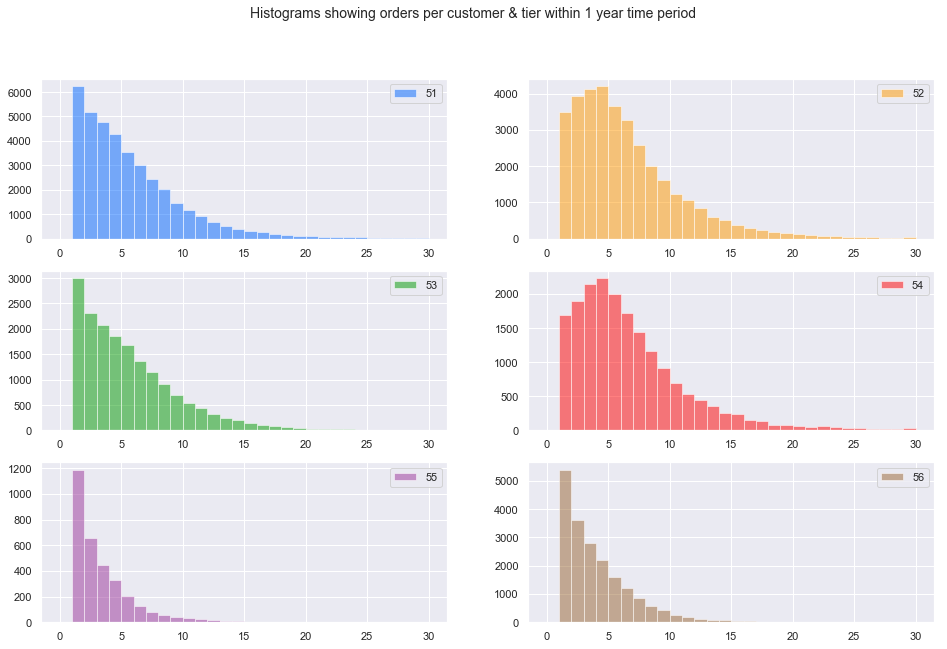

,Tier 51 ORDERS,Tier 52 ORDERS,Tier 53 ORDERS,Tier 54 ORDERS,Tier 55 ORDERS,Tier 56 ORDERS
count,38241.00,35167.00,17466.00,18656.00,3235.00,19594.00
mean,5.35,6.17,5.33,6.42,2.99,3.64
std,4.60,5.21,4.61,5.33,2.67,3.30
min,1.00,1.00,1.00,1.00,1.00,1.00
25%,2.00,3.00,2.00,3.00,1.00,1.00
50%,4.00,5.00,4.00,5.00,2.00,3.00
75%,7.00,8.00,7.00,8.00,4.00,5.00
max,90.00,187.00,102.00,90.00,28.00,188.00


In [38]:
sns.set()
plt.figure(figsize=(16,10))
plt.suptitle('Histograms showing orders per customer & tier within 1 year time period', fontsize=14)
plt.subplot(321)
data_tier_51 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 51]
data_tier_51['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#0066ff', alpha=0.5)
plt.legend([51])
plt.subplot(322)
data_tier_52 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 52]
data_tier_52['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff9900', alpha=0.5)
plt.legend([52])
plt.subplot(323)
data_tier_53 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 53]
data_tier_53['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#009900', alpha=0.5)
plt.legend([53])
plt.subplot(324)
data_tier_54 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 54]
data_tier_54['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#ff0000', alpha=0.5)
plt.legend([54])
plt.subplot(325)
data_tier_55 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 55]
data_tier_55['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#993399', alpha=0.5)
plt.legend([55])
plt.subplot(326)
data_tier_56 = t_customers[t_customers['CZP_ZTQ_ID_unique'] == 56]
data_tier_56['SCM_N_ORDER_NR_len'].hist(bins=30, range=(0, 30), color='#996633', alpha=0.5)
plt.legend([56])
plt.show() 

concat_df = pd.DataFrame()
for tq in ztq:
    data_tier = t_customers[t_customers['CZP_ZTQ_ID_unique'] == tq]
    concat_df = pd.concat([concat_df,
                           pd.DataFrame(data_tier['SCM_N_ORDER_NR_len'].describe().round(2)),
                           ], axis=1)
concat_df.columns = ['Tier 51 ORDERS', 'Tier 52 ORDERS', 'Tier 53 ORDERS',
                     'Tier 54 ORDERS', 'Tier 55 ORDERS', 'Tier 56 ORDERS']
display(concat_df)

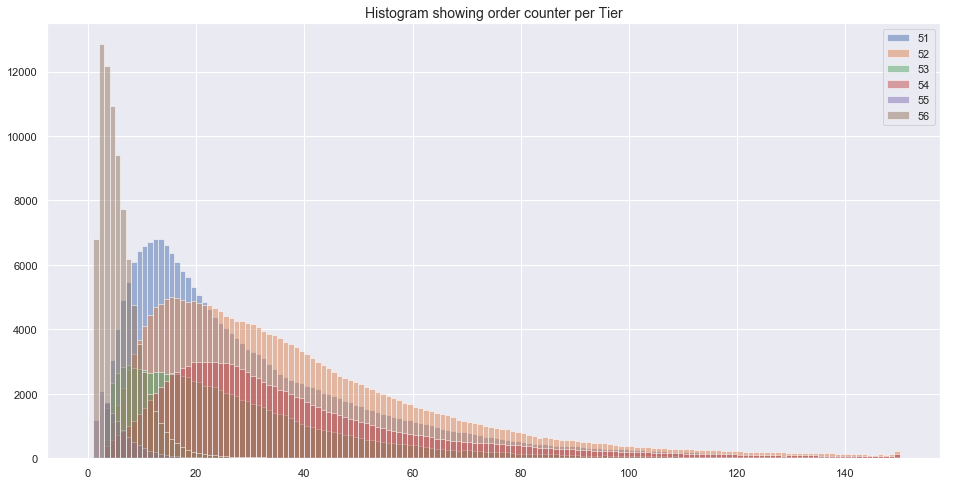

,Tier 51 Order_Counter,Tier 52 Order_Counter,Tier 53 Order_Counter,Tier 54 Order_Counter,Tier 55 Order_Counter,Tier 56 Order_Counter
count,230129.00,242631.00,102117.00,130365.00,11438.00,86043.00
mean,33.84,42.60,30.10,44.94,5.17,6.33
std,32.34,37.68,34.03,50.14,4.39,12.02
min,2.00,2.00,2.00,1.00,1.00,1.00
25%,13.00,19.00,12.00,20.00,2.00,3.00
50%,24.00,33.00,23.00,32.00,4.00,5.00
75%,44.00,54.00,37.00,52.00,7.00,7.00
max,404.00,570.00,921.00,3246.00,61.00,423.00


In [39]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order counter per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_counter_values = [i for i in data_tier['OSP_KO_COUNT_NET'].values]
    plt.hist(order_counter_values, bins=150, range=(0, 150), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_counter_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Counter', 'Tier 52 Order_Counter', 'Tier 53 Order_Counter',
                     'Tier 54 Order_Counter', 'Tier 55 Order_Counter', 'Tier 56 Order_Counter']
display(concat_df)

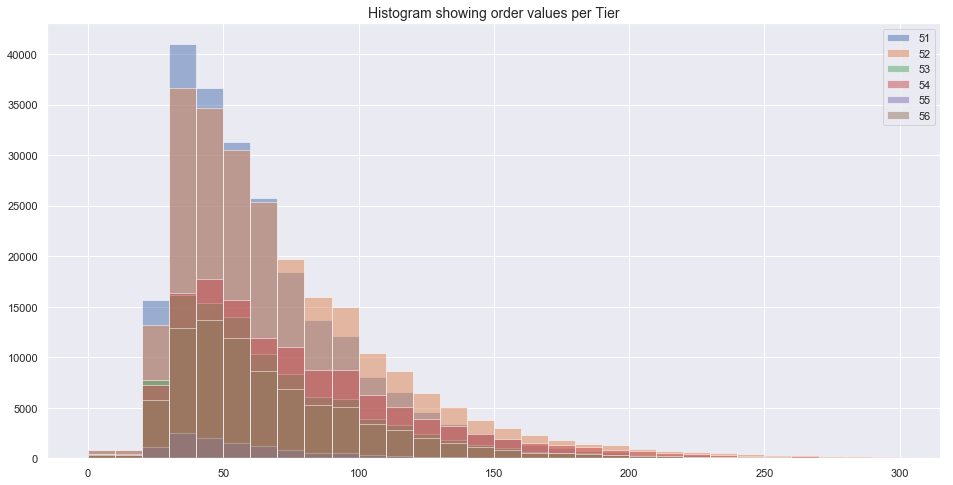

,Tier 51 Order_Values,Tier 52 Order_Values,Tier 53 Order_Values,Tier 54 Order_Values,Tier 55 Order_Values,Tier 56 Order_Values
count,230129.00,242631.00,102117.00,130365.00,11438.00,86043.00
mean,66.34,74.20,68.99,80.23,60.29,71.24
std,42.52,49.37,43.43,57.64,36.03,51.11
min,-40.03,-105.57,-22.25,-62.01,-12.70,-26.50
25%,39.74,42.67,40.82,45.12,36.15,41.79
50%,56.19,61.10,56.99,65.68,50.41,57.93
75%,80.96,92.14,85.49,99.20,72.71,87.35
max,2470.95,6220.70,1626.05,2778.62,479.13,2162.91


In [40]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing order values per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values = [i for i in data_tier['SCM_SALES_BMF'].values]
    plt.hist(order_values, bins=30, range=(0, 300), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(order_values).describe().round(2)),
                           ], axis=1)
plt.show() 

concat_df.columns = ['Tier 51 Order_Values', 'Tier 52 Order_Values', 'Tier 53 Order_Values',
                     'Tier 54 Order_Values', 'Tier 55 Order_Values', 'Tier 56 Order_Values']
display(concat_df)

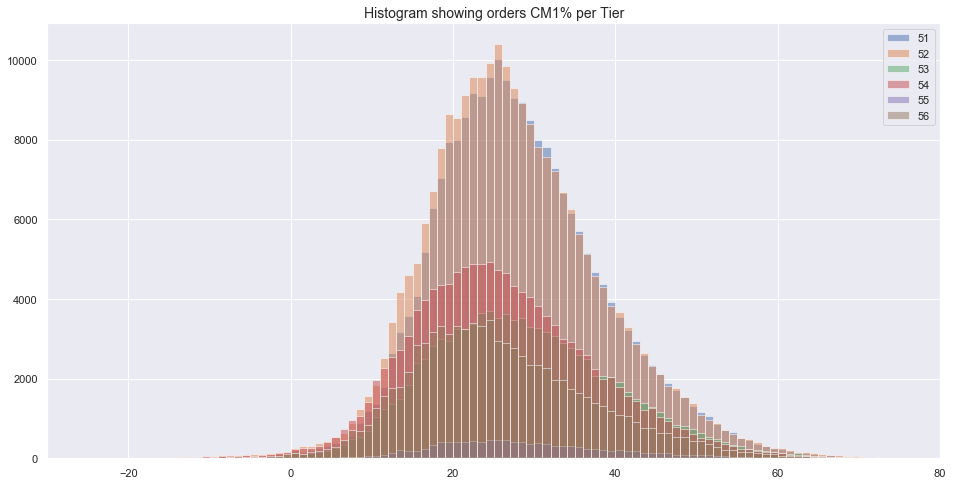

,Tier 51 Order_CM1%,Tier 52 Order_CM1%,Tier 53 Order_CM1%,Tier 54 Order_CM1%,Tier 55 Order_CM1%,Tier 56 Order_CM1%
count,230103.00,242606.00,102105.00,130349.00,11434.00,86026.00
25%,21.14,20.26,20.43,18.19,20.81,17.93
50%,27.29,26.59,27.75,25.10,27.34,24.42
75%,34.62,34.10,36.02,33.14,35.58,32.72


In [41]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM1% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm1 = [i for i in data_tier['SCM_D_FINANCE_CM1'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm1 = [i/j * 100 for i, j in list(zip(order_values_cm1, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm1, bins=100, range=(-25, 75), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm1).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM1%', 'Tier 52 Order_CM1%', 'Tier 53 Order_CM1%',
                     'Tier 54 Order_CM1%', 'Tier 55 Order_CM1%', 'Tier 56 Order_CM1%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

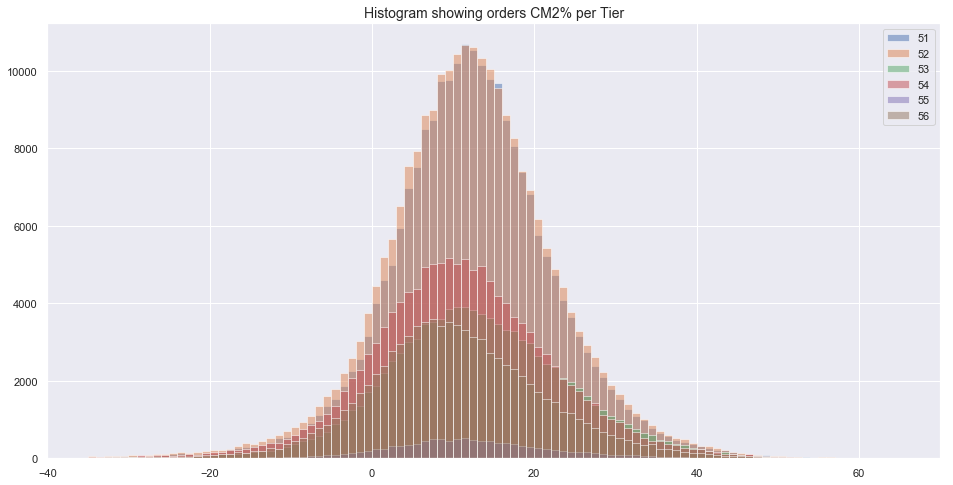

,Tier 51 Order_CM2%,Tier 52 Order_CM2%,Tier 53 Order_CM2%,Tier 54 Order_CM2%,Tier 55 Order_CM2%,Tier 56 Order_CM2%
count,230103.00,242606.00,102105.00,130349.00,11434.00,86026.00
25%,6.28,5.74,5.64,3.89,5.55,3.35
50%,12.20,11.97,12.56,10.64,11.59,9.71
75%,18.36,18.36,20.17,17.84,18.33,16.95


In [42]:
concat_df = pd.DataFrame()
sns.set()
plt.figure(figsize=(16,8))
plt.title('Histogram showing orders CM2% per Tier', fontsize=14)

for tq in ztq:
    data_tier = orders[orders['CZP_ZTQ_ID'] == tq]
    order_values_cm2 = [i for i in data_tier['SCM_D_FINANCE_CM2'].values]
    order_values_net_sales = [i for i in data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].values]
    orders_rel_cm2 = [i/j * 100 for i, j in list(zip(order_values_cm2, order_values_net_sales)) if j != 0]
    plt.hist(orders_rel_cm2, bins=100, range=(-35, 65), alpha=0.5)
    plt.legend([51, 52, 53, 54, 55, 56])
    concat_df = pd.concat([concat_df,
                           (pd.DataFrame(orders_rel_cm2).describe().round(2)),
                           ], axis=1)

plt.legend([51, 52, 53, 54, 55, 56])
plt.show() 

concat_df.columns = ['Tier 51 Order_CM2%', 'Tier 52 Order_CM2%', 'Tier 53 Order_CM2%',
                     'Tier 54 Order_CM2%', 'Tier 55 Order_CM2%', 'Tier 56 Order_CM2%']
display(concat_df.loc[['count', '25%', '50%', '75%']].astype(float))

In [43]:
metrics_ztq = pd.DataFrame(columns=['ZTQ','active_customers', 'orders', 'sales_bmf', 'net_sales', 'CM1', 'CM2', 'CM1%', 'CM2%',
                                   'discount_amount', 'orders_%_neg_cm1', 'loss_in_CM1', 'orders_%_neg_cm2', 'loss_in_CM2'])
for tq in ztq:
    df_elems = []
    data_tier = data[data['CZP_ZTQ_ID'] == tq]
    df_elems.append(tq)
    df_elems.append(data_tier['CUS_N_KEY_CUSTOMER'].nunique())
    df_elems.append(data_tier['SCM_N_ORDER_NR'].nunique())
    df_elems.append(data_tier['SCM_SALES_BMF'].sum())
    df_elems.append(data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum())
    df_elems.append(data_tier['SCM_D_FINANCE_CM1'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append(data_tier['SCM_D_FINANCE_CM2'].sum() / data_tier['SCM_D_ORIG_FINANCE_ORDER_NET'].sum() * 100)
    df_elems.append((data_tier[data_tier['SCM_MASTER_AP_ID'] == 42715]['SCM_SALES_BMF']).sum())
    
    cm1_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM1'].sum()
    orders_neg_cm1 = cm1_per_order[cm1_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm1)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm1_per_order[cm1_per_order < 0].sum())
    
    cm2_per_order = data_tier.groupby('SCM_N_ORDER_NR')['SCM_D_FINANCE_CM2'].sum()
    orders_neg_cm2 = cm2_per_order[cm2_per_order < 0].index.values
    df_elems.append(len(orders_neg_cm2)/data_tier['SCM_N_ORDER_NR'].nunique()*100)
    df_elems.append(cm2_per_order[cm2_per_order < 0].sum())
    
    new_row = pd.DataFrame.from_records([df_elems], columns=metrics_ztq.columns)
    metrics_ztq = metrics_ztq.append(new_row, ignore_index=True)
    
display(metrics_ztq.round(2))

,ZTQ,active_customers,orders,sales_bmf,net_sales,CM1,CM2,CM1%,CM2%,discount_amount,orders_%_neg_cm1,loss_in_CM1,orders_%_neg_cm2,loss_in_CM2
0,51,45056,230129,15266991.29,12644813.95,3429050.04,1691971.07,27.12,13.38,-469879.21,0.55,-3279.01,9.42,-51780.65
1,52,41066,242631,18004078.47,14913963.31,3939890.54,1957020.92,26.42,13.12,-557556.61,0.75,-5174.62,10.69,-69464.33
2,53,19872,102117,7044947.68,5835442.09,1599334.50,819654.06,27.41,14.05,-369324.47,0.69,-2051.59,11.28,-28522.03
3,54,20880,130365,10458822.15,8663114.58,2164142.01,1046000.23,24.98,12.07,-552145.31,1.05,-4497.74,14.69,-56276.57
4,55,3695,11438,689636.80,570765.14,156367.87,74581.42,27.40,13.07,-21100.59,0.49,-166.34,10.47,-2578.11
5,56,23422,86043,6129639.67,5074462.51,1246422.67,572564.13,24.56,11.28,-320216.23,0.80,-1982.50,15.51,-34807.35
